In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import VAR
from statsmodels.sandbox.regression.gmm import GMM
from scipy.optimize import minimize
from scipy.stats import norm
from statsmodels.tsa.filters.hp_filter import hpfilter

##Кривая Филлипса



###Phillips

inflation ~ unemployment (инфляция коррелирует с безработицей)

**CPI**: индекс потребительских цен, Росстат, Индексы потребительских цен на товары и услуги по Российской Федерации в 1991-2025гг.


**unemployment**: уровень безработицы, Росстат, Уровень безработицы населения в возрасте 15-72 лет по субъектам Российской Федерации 2000-2024гг

In [3]:
df = pd.read_csv('data_basic_phillips.csv', sep=';')

df.head()

,Year,CPI,unemployment
0,2000,"120,2","10,6"
1,2001,"118,6","9,0"
2,2002,"115,1","7,9"
3,2003,"112,0","8,2"
4,2004,"111,7","7,8"


In [4]:
cols = ["CPI", "unemployment"]
df['CPI'] = df['CPI'].str.replace(',', '.')
df['unemployment'] = df['unemployment'].str.replace(',', '.')
df[cols] = df[cols].astype(float)

In [5]:
df.describe()

,Year,CPI,unemployment
count,25.000000,25.000000,25.00000
mean,2012.000000,109.644000,6.16800
std,7.359801,4.445979,1.84836
min,2000.000000,102.500000,2.50000
25%,2006.000000,106.500000,5.20000
50%,2012.000000,109.000000,5.80000
75%,2018.000000,111.900000,7.30000
max,2024.000000,120.200000,10.60000


In [6]:
X = df['unemployment'].values.reshape(-1, 1)
y = df['CPI'].values

model = LinearRegression()
model.fit(X, y)

a = model.coef_[0]
b = model.intercept_

x_line = np.linspace(df['unemployment'].min(), df['unemployment'].max(), 100)
y_line = a * x_line + b

print(f'inflation rate = {a:.2f} * unemployment + {b:.2f}')

print(f'r^2 = {model.score(X, y):.2f}')

inflation rate = 1.46 * unemployment + 100.62
r^2 = 0.37


Модель описывает 37% выборки (что довольно мало) и показывает положительную корреляцию между инфляцией и безработицей

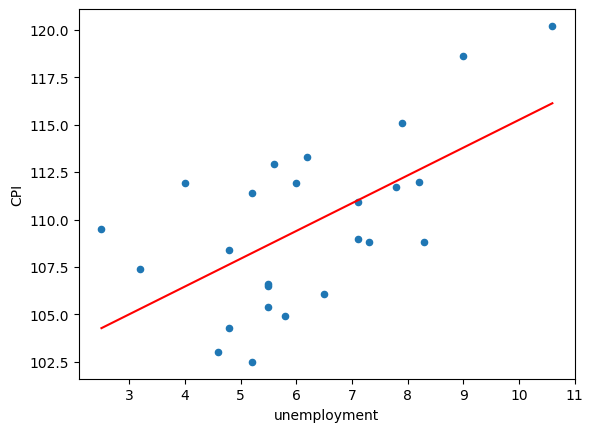

In [7]:
df.plot.scatter(y='CPI', x='unemployment')
plt.plot(x_line, y_line, color='red', label='Линия регрессии')
plt.show()

###Phillips–Lipsey


Δw ~ u + Δu, где


w - заработная плата,
u - безработица

Тут аналогично статье в качестве инфляции используется изменение заработной платы

unemployment: уровень безработицы, Росстат, Уровень безработицы населения в возрасте 15-72 лет по субъектам Российской Федерации 2000-2024гг

wage: заработная плата, Росстат, Динамика уровня и структуры затрат на рабочую силу по Российской Федерации (умножала Среднемесячные затраты на рабочую силу на процент заработной платы)

dwage: $(wage_t - wage_{t-n})/ n$

dunemployment аналогично

In [9]:
df = pd.read_csv('data_phillips-lipsey.csv', sep=';')

df.head()

,year,wage,dwage,unemployment,dunemployment
0,2002,"5488,39","1310,21","9,0","-0,80"
1,2005,"10215,9","1575,83666666667","7,9","-0,37"
2,2007,"16112,1","2948,1","8,2","0,15"
3,2009,"22329,1","3108,5","7,8","-0,20"
4,2013,"34586,1","3064,25","7,1","-0,18"


In [10]:
cols = ["wage", "dwage", "unemployment", "dunemployment"]
df['wage'] = df['wage'].str.replace(',', '.')
df['dwage'] = df['dwage'].str.replace(',', '.')
df['dunemployment'] = df['dunemployment'].str.replace(',', '.')
df['unemployment'] = df['unemployment'].str.replace(',', '.')
df[cols] = df[cols].astype(float)

In [11]:
df.describe()

,year,wage,dwage,unemployment,dunemployment
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,2010.571429,28919.470000,2936.410238,7.585714,-0.240000
std,6.778819,22298.524859,1517.912616,0.958173,0.301938
min,2002.000000,5488.390000,1310.210000,6.000000,-0.800000
25%,2006.000000,13164.000000,2080.493333,7.100000,-0.325000
50%,2009.000000,22329.100000,2948.100000,7.800000,-0.200000
75%,2015.000000,39756.400000,3086.375000,8.050000,-0.090000
max,2021.000000,68778.000000,5962.825000,9.000000,0.150000


In [12]:
ols = smf.ols('dwage ~ unemployment + dunemployment', data=df).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  dwage   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     4.994
Date:                Mon, 08 Sep 2025   Prob (F-statistic):             0.0818
Time:                        23:40:22   Log-Likelihood:                -56.287
No. Observations:                   7   AIC:                             118.6
Df Residuals:                       4   BIC:                             118.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.308e+04   3382.415      3.867

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Модель объясняет около 71,4% вариации зависимой переменной(изменение заработной платы), однако скорректированный коэффициент детерминации (Adj. R-squared) стал ниже — 57,1%, что свидетельствует о влиянии небольшого числа наблюдений (всего 7).


Коэффициент при константе положительный и значим на уровне 5% (p = 0.018), что указывает на позитивное базовое значение dwage без учёта остальных переменных. Переменная unemployment негативно связана с dwage и также значима (p = 0.044), что говорит о том, что рост безработицы снижает изменение заработной платы. Переменная dunemployment статистически незначима (p = 0.991), и её вклад в модель отсутствует.

In [13]:
coefficients = ols.params
print(f"Δw = {coefficients['Intercept']:.1f} + {coefficients['unemployment']:.1f} * u + {coefficients['dunemployment']:.1f} * Δu")

Δw = 13078.7 + -1336.4 * u + 18.1 * Δu


###Calvo–Yun Phillips curve (NKPC)

$${\pi}_t=\beta {E}_t{\pi}_{t+1}+\frac{\left(1-\beta \theta \right)\left(1-\theta \right)}{\theta } AD{s}_t$$

где $\pi$ - инфляция, s - предельные издержки представительной фирмы, $\beta$ - коэффициент временного дисконтирования представительного домохозяйства ($0<\beta< 1$), A - коэффициент, зависящий от формы кривой спроса фирмы, отражающий переменную наценку ($0<A≤1$, $A=1$ при постоянной наценке), D - коэффициент, зависящий от формы кривой предложения фирмы, отражающий эффект корректировки капитала ($0<D≤1$ обычно $D=1$), $\theta$ - параметр, связанный с частотой корректировки цен фирмами ($0<\theta<1$)


Будем строить модель используя GMM с инструментальными переменными (лаги инфдяции, процентной ставки и предельных издержек)

$$
\pi_t = \lambda \, rmc_t + \beta \, E_t\{\pi_{t+1}\}
$$


s - обычно берется как доля дохода от труда (сайт Росстата) или производственный разрыв


инфляцию получаем тоже на сайте Росстата (ИПЦ)

In [16]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

np.random.seed(42)
N = 100
pi = np.random.randn(N)              # инфляция в момент t
rmc = np.random.randn(N)             # реальный предельный издержки в момент t
interest_rate = np.random.randn(N)   # процентная ставка (для инструментальных переменных)

# Сдвиг инфляции вперед для прокси ожидаемой инфляции Et[pi_{t+1}]
pi_plus1 = np.roll(pi, -1)
pi_plus1[-1] = np.nan

df = pd.DataFrame({'pi': pi, 'rmc': rmc, 'interest_rate': interest_rate})
def create_instruments( lags=4):
    instruments = pd.DataFrame()
    for lag in range(1, lags+1):
        instruments[f'pi_lag{lag}'] = df['pi'].shift(lag)
        instruments[f'rmc_lag{lag}'] = df['rmc'].shift(lag)
        instruments[f'int_lag{lag}'] = df['interest_rate'].shift(lag)
    return instruments.dropna()

instruments = create_instruments()
min_len = len(instruments)
pi = pi[-min_len:]
pi_plus1 = pi_plus1[-min_len:]
rmc = rmc[-min_len:]
mask = ~np.isnan(pi_plus1)
pi, pi_plus1, rmc, instruments = pi[mask], pi_plus1[mask], rmc[mask], instruments.iloc[mask]

def moments(params, pi, pi_plus1, rmc, Z):
    beta, lambd = params
    err = pi - beta * pi_plus1 - lambd * rmc
    return err[:, None] * Z.values
def gmm_objective(params, pi, pi_plus1, rmc, Z):
    m = moments(params, pi, pi_plus1, rmc, Z)
    mean_m = m.mean(axis=0)
    return mean_m @ mean_m


init_params = np.array([0.5, 0.5])
bounds = [(0, 1), (None, None)]  # beta от 0 до 1, lambda без ограничений


res = minimize(gmm_objective, init_params, args=(pi, pi_plus1, rmc, instruments),
               method='L-BFGS-B', bounds=bounds, options={'maxiter': 10000})
print(f'Оценённые параметры:\n beta = {res.x[0]:.4f}, lambda = {res.x[1]:.4f}')



Оценённые параметры:
 beta = 0.0320, lambda = -0.1811


###Hybrid Calvo–Yun Phillips curve (HNKPC)


$$
\pi_t = \lambda \, rmc_t + \gamma_f \, E_t\{\pi_{t+1}\} + \gamma_b \, \pi_{t-1}
$$


К NKPC добавляется инфляция прошлого периода ($\pi_{t-1}$)

In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

np.random.seed(42)
N = 120
pi = np.random.randn(N)                   # инфляция t
rmc = np.random.randn(N)                  # реальный предельный издержки t
interest_rate = np.random.randn(N)        # процентная ставка t (например, межбанк)


def create_instruments(pi, rmc, interest_rate, max_lag=4):
    df = pd.DataFrame({'pi': pi, 'rmc': rmc, 'int': interest_rate})
    instr = pd.DataFrame()
    for lag in range(1, max_lag+1):
        instr[f'pi_lag{lag}'] = df['pi'].shift(lag)
        instr[f'rmc_lag{lag}'] = df['rmc'].shift(lag)
        instr[f'int_lag{lag}'] = df['int'].shift(lag)
    return instr.dropna()

instruments = create_instruments(pi, rmc, interest_rate, max_lag=4)
min_len = len(instruments)
pi = pi[-min_len:]
rmc = rmc[-min_len:]
interest_rate = interest_rate[-min_len:]
pi_plus1 = np.roll(pi, -1)
pi_plus1[-1] = np.nan
pi_lag1 = np.roll(pi, 1)
pi_lag1[0] = np.nan
mask = ~(np.isnan(pi_plus1) | np.isnan(pi_lag1))
pi = pi[mask]
pi_plus1 = pi_plus1[mask]
pi_lag1 = pi_lag1[mask]
rmc = rmc[mask]
instruments = instruments.iloc[mask]

def moments(params, pi, pi_plus1, pi_lag1, rmc, Z):
    lambd, gamma_f, gamma_b = params
    error = pi - (lambd * rmc + gamma_f * pi_plus1 + gamma_b * pi_lag1)
    return error[:, None] * Z.values
def gmm_objective(params, pi, pi_plus1, pi_lag1, rmc, Z):
    m = moments(params, pi, pi_plus1, pi_lag1, rmc, Z)
    mean_m = m.mean(axis=0)
    return mean_m @ mean_m

init_params = np.array([0.01, 0.8, 0.1])
bounds = [(None, None), (0, 1), (0, 1)]
res = minimize(gmm_objective, init_params, args=(pi, pi_plus1, pi_lag1, rmc, instruments),
               method='L-BFGS-B', bounds=bounds, options={'maxiter': 10000})

print("Оценка параметров гибридной NKPC:")
print(f"lambda   = {res.x[0]:.4f}")
print(f"gamma_f  = {res.x[1]:.4f}  (коэффициент ожидаемой инфляции)")
print(f"gamma_b  = {res.x[2]:.4f}  (коэффициент лаговой инфляции)")



Оценка параметров гибридной NKPC:
lambda   = -0.2660
gamma_f  = 0.0000  (коэффициент ожидаемой инфляции)
gamma_b  = 0.0149  (коэффициент лаговой инфляции)


##Правило Тейлора

###$$i_t= \alpha + {\beta}_{\pi}\left(\pi -{\pi}^{*}\right)+{\beta}_q\left( q-{q}^{*}\right) + \epsilon_t$$

q - ВВП, $\pi$ - инфляция, q* - потенциальный ВВП

До 2015 не было таргетирования инфляции, берем данные после 2015 года по кварталам

${\pi}^{*}$ считаем равной таргетируемой инфляции (4%)

GDR: Реальный ВВП, Росстат, Валовой внутрений продукт
(в текущих ценах, млрд.руб.) по кварталам 2015 - 2025.1

rate: Ключевая ставка, Банк РФ, https://cbr.ru/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&U


inflation: индекс потребительских цен, Росстат, Квартальные индексы потребительских цен на товары и услуги по Российской Федерации в 2005-2025 гг. Вычитала 100.



In [20]:
df = pd.read_csv('data_taylor_rule.csv', sep=';')
cols = ["GDP", "inflation", "rate", "dGDP", 'prev_rate']
df['GDP'] = df['GDP'].str.replace(',', '.')
df['dGDP'] = df['dGDP'].str.replace(',', '.')
df['inflation'] = df['inflation'].str.replace(',', '.')
df['rate'] = df['rate'].str.replace(',', '.')
df['prev_rate'] = df['prev_rate'].str.replace(',', '.')
df[cols] = df[cols].astype(float)
df['inflation'] = df['inflation']-100

In [21]:
df.head()

,GDP,inflation,rate,dGDP,prev_rate
0,18467.9,7.44,15.33,0.0,0.00
1,19751.0,1.00,12.88,1283.1,15.33
2,21788.6,1.73,11.17,2037.6,12.88
3,23079.8,2.28,11.00,1291.2,11.17
4,18885.1,2.07,11.00,-4194.7,11.00


In [22]:
df.describe()

,GDP,inflation,rate,dGDP,prev_rate
count,41.000000,41.000000,41.000000,41.000000,41.000000
mean,31674.521951,1.739268,9.871463,714.119512,9.359268
std,10583.791537,1.841463,4.195550,3999.546634,4.083353
min,18467.900000,-0.860000,4.250000,-11132.600000,0.000000
25%,23718.200000,0.970000,7.290000,-1090.600000,7.270000
50%,27854.500000,1.330000,8.290000,1782.900000,8.250000
75%,39156.100000,1.980000,11.170000,3435.100000,11.000000
max,58879.400000,9.950000,21.000000,8022.300000,20.420000


С помощью фильтра Ходрика—Прескотта (HP-filter) получим потенциальный ВВП

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


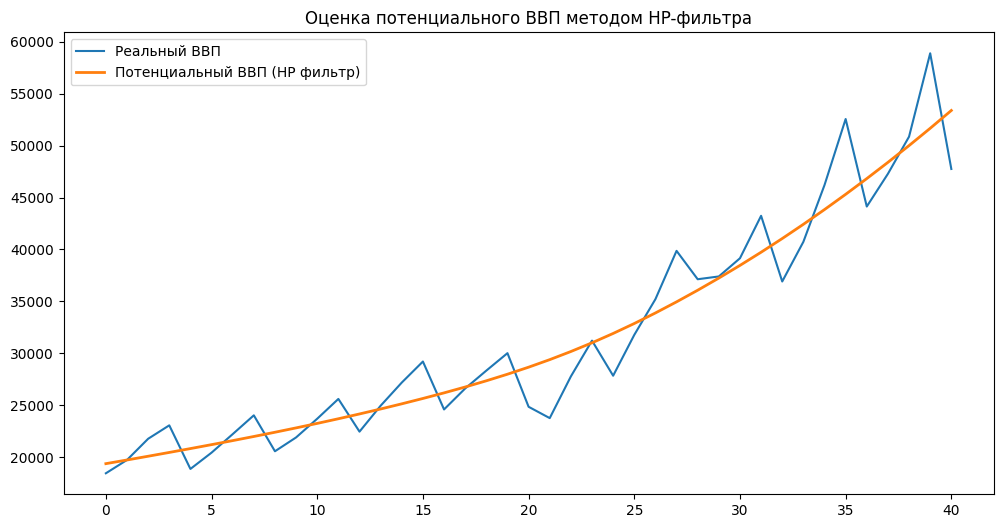

In [23]:
gdp_log = np.log(df['GDP'])
cycle, trend = hpfilter(gdp_log, lamb=1600)


df['potential_GDP'] = np.exp(trend)
df['output_Gap'] = np.exp(cycle)

plt.figure(figsize=(12,6))
plt.plot(df.index, df['GDP'], label='Реальный ВВП')
plt.plot(df.index, df['potential_GDP'], label='Потенциальный ВВП (HP фильтр)', linewidth=2)
plt.legend()
plt.title('Оценка потенциального ВВП методом HP-фильтра')
plt.show()

In [24]:
df['inflation_Gap']= df['inflation'] - 4

df.head()

,GDP,inflation,rate,dGDP,prev_rate,potential_GDP,output_Gap,inflation_Gap
0,18467.9,7.44,15.33,0.0,0.00,19393.049010,0.952295,3.44
1,19751.0,1.00,12.88,1283.1,15.33,19747.313504,1.000187,-3.00
2,21788.6,1.73,11.17,2037.6,12.88,20107.435260,1.083609,-2.27
3,23079.8,2.28,11.00,1291.2,11.17,20472.875817,1.127336,-1.72
4,18885.1,2.07,11.00,-4194.7,11.00,20844.098573,0.906017,-1.93


In [25]:
# Код для получения данных по ключевой ставке по кварталам

# df = pd.read_csv('data_rate.csv', sep=';')
# cols = ["I"]
# df['I'] = df['I'].str.replace(',', '.')
# df[cols] = df[cols].astype(float)
# df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')

# df['quarter'] = df['Date'].dt.to_period('Q')
# quarterly_avg = df.groupby('quarter')['I'].mean()

# print(quarterly_avg)

Используем обычную линейную регрессию

In [26]:
ols = smf.ols('rate ~ inflation_Gap + output_Gap', data=df).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     4.130
Date:                Tue, 09 Sep 2025   Prob (F-statistic):             0.0238
Time:                        00:36:04   Log-Likelihood:                -112.43
No. Observations:                  41   AIC:                             230.9
Df Residuals:                      38   BIC:                             236.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.1700      7.458      0.693

In [27]:
coefficients = ols.params
print(f"i = {coefficients['Intercept']:.1f} + {coefficients['inflation_Gap']:.1f} * (pi - pi*) + {coefficients['output_Gap']:.1f} * (q - q*)")

i = 5.2 + 0.9 * (pi - pi*) + 6.7 * (q - q*)


Регрессия методом наименьших квадратов показала, что модель в целом статистически значима (p=0.0238), но объясняет лишь около 17.9% выборки. Коэффициент при переменной inflation_Gap значим на уровне 5% (p=0.011) и положительно влияет на rate, что указывает на связь роста инфляционного разрыва с повышением ставки. Коэффициент при output_Gap статистически не значим (p=0.366). Константа также не значима (p=0.492).

Попробуем оценить ГЭП инфляции тоже с помощью фильтра Ходрика—Прескотта (HP-filter)

In [28]:
cycle, trend = hpfilter(df['inflation'], lamb=1600)
df['inflation_Gap_HP'] = cycle

ols = smf.ols('rate ~ inflation_Gap_HP + output_Gap', data=df).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.542
Date:                Tue, 09 Sep 2025   Prob (F-statistic):              0.227
Time:                        00:36:04   Log-Likelihood:                -114.87
No. Observations:                  41   AIC:                             235.7
Df Residuals:                      38   BIC:                             240.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.5148      7.827  

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


###$$i=\left({r}^{*}+{\pi}^{*}\right)+{\theta}_i({i}_{-1}-({r}^{*}+{\pi}^{*}))+{\theta}_{\pi}\left(\pi -{\pi}^{*}\right)+{\theta}_q\left( q-{q}^{*}\right)+{\theta}_{\Delta q}\left(\Delta q-\Delta {q}^{*}\right)$$

В классическую модель добавляется разрыв роста ВВП и ставка предыдущего периода

Для России r* оценивается в диапазоне 2-4%, возьмем 3%

ГЭП роста ВВП оценим через HP - фильтр

In [31]:
cycle, trend = hpfilter(df['dGDP'], lamb=1600)
df['dGDP_Gap'] = cycle

df['rate_Gap'] = df['prev_rate'] - 3 - 4
df['rate_new'] = df['rate'] -7

df = df[1:] #убираем первую строчку, тк prev_rate dGDP для нее не определен

df.head()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


,GDP,inflation,rate,dGDP,prev_rate,potential_GDP,output_Gap,inflation_Gap,inflation_Gap_HP,dGDP_Gap,rate_Gap,rate_new
2,21788.6,1.73,11.17,2037.6,12.88,20107.435260,1.083609,-2.27,-0.497633,1534.604667,5.88,4.17
3,23079.8,2.28,11.00,1291.2,11.17,20472.875817,1.127336,-1.72,0.213160,798.439284,4.17,4.00
4,18885.1,2.07,11.00,-4194.7,11.00,20844.098573,0.906017,-1.93,0.156862,-4679.146963,4.00,4.00
5,20452.2,1.21,10.89,1567.1,11.00,21223.186433,0.963672,-2.79,-0.558529,1087.106904,4.00,3.89
6,22235.1,0.72,10.42,1782.9,10.89,21611.035963,1.028877,-3.28,-0.915107,1304.486333,3.89,3.42


Используем обычную линейную регрессию

In [32]:
ols = smf.ols('rate_new ~ inflation_Gap + output_Gap + dGDP_Gap + rate_Gap - 1', data=df).fit()
print(ols.summary())

                                 OLS Regression Results                                
Dep. Variable:               rate_new   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              166.6
Date:                Tue, 09 Sep 2025   Prob (F-statistic):                    2.89e-22
Time:                        00:36:39   Log-Likelihood:                         -58.897
No. Observations:                  39   AIC:                                      125.8
Df Residuals:                      35   BIC:                                      132.4
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

Модель демонстрирует высокую объясняющую способность с коэффициентом детерминации около 0.95. Коэффициенты при переменных inflation_Gap (0.7725) и rate_Gap (0.9893) статистически значимы (p = 0.000). Переменная dGDP_Gap статистически незначима.

rate_Gap имеет больший кожфициент чем inflation_Gap, а backward-looking важнее, чем forward-looking.